# Multi-Classification Modeling with top 4 beacons with DNN
## Index
- Load data & import modules
- Preprocessing & split
- DNN modeling
- Ploting 
- Confusion Matrix


# Load data & import moduels
- tensorflow version 2.9.1 required

In [ ]:
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
%cd drive/MyDrive/BEST/ios_clf_direction

[Errno 2] No such file or directory: 'drive/MyDrive/BEST/ios_clf_direction'
/content/drive/MyDrive/BEST/ios_clf_direction


In [ ]:
datas = [] 
data_name = [('S', [1,2,3,4,5,6,7,8,9]), ('E', [1,2,3]), ('R',[1,2,3,4,5]), ('H', [1,2]), ('A', [1,2,3,4,5,6,7,8,9,10,11]), ('U', [1]) ]

#ios_clf_data_4_concatedS04

for data in data_name:
  for index in data[1]: 
    if index < 10:
      no_supervised = pd.DataFrame(pd.read_csv(f'ios_clf_data_4_concated{data[0]}0{index}.csv'))
    else:
      no_supervised = pd.DataFrame(pd.read_csv(f'ios_clf_data_4_concated{data[0]}{index}.csv'))
    datas.append(no_supervised)

In [ ]:
!pip install wurlitzer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import math

try:
  from wurlitzer import sys_pipes
except:
  from colabtools.googlelog import CaptureLog as sys_pipes

from IPython.core.magic import register_line_magic
from IPython.display import Javascript

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVR
from sklearn import preprocessing
from sklearn import utils
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pathlib

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
print(tf.__version__)

2.8.2


# Preprocessing & split
- Concat all the data
- split into 7:3

In [ ]:
result = pd.concat(datas)

In [ ]:
result.loc[result['location'] == 'A011', 'location'] = 'A11'
result.loc[result['location'] == 'A010', 'location'] = 'A10'

In [ ]:
result.drop('Unnamed: 0', axis=1, inplace=True)

In [ ]:
result.columns

Index(['location', '001', '002', '003', '004', '005', '006', '007', '008',
       '009', '010', '011', '012', '013', '014', '015', '016', '017', '018',
       '019', '020', '021', '022'],
      dtype='object')

In [ ]:
len(result)

30806

# DNN modeling
- Multi-Classification with Top 5 beacons


# Hyperparameter Tuning
- Normalization : Weight Normalization
- learning rate : [0.01, 0.001, 0.0001]
- loss: categorical_crossentropy
- Optimaization: Adam
- epoch: 50
- output layer: 31
- activation: Relu
- activation: Softmax

# Result
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 224 and the optimal learning rate for the optimizer
is 0.001.

- loss: 0.2959
- accuracy: 0.8853 
- precision: 0.8909 
- recall: 0.8813 
- f1_score: 0.8779 
- 450ms/epoch - 3ms/step


In [20]:
np.set_printoptions(precision=2)
le = LabelEncoder()

X = np.array(result.iloc[:, 1:])
y = le.fit_transform(np.array(result['location']).reshape(-1, 1))
y = to_categorical(y)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [21]:
len(X[0])

22

In [22]:
X = np.asarray(X).astype(np.float32)

In [23]:
len(X[0])

22

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42,shuffle=True)

In [25]:
!pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 5.1 MB/s 


In [26]:
import tensorflow_addons as tfa

In [27]:
class ClearTrainingOutput(tf.keras.callbacks.Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)

In [28]:
!pip install IPython
import IPython

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [29]:
tf.random.set_seed(42)
initializer = tf.keras.initializers.HeNormal()

def model_builder(hp):
   model = keras.Sequential()
    
   # Dense layer unit number 32~256
   hp_unit = hp.Int('units', min_value=32, max_value=256, step=32)
   model.add(tfa.layers.WeightNormalization(tf.keras.layers.Dense(units=hp_unit, activation = tf.keras.activations.relu, input_shape=[22], kernel_initializer=initializer)))
   model.add(tfa.layers.WeightNormalization(tf.keras.layers.Dense(units=hp_unit, activation = tf.keras.activations.relu, input_shape=[22],kernel_initializer=initializer)))
   model.add(tfa.layers.WeightNormalization(tf.keras.layers.Dense(units=hp_unit, activation = tf.keras.activations.relu, input_shape=[22],kernel_initializer=initializer)))
  #  model.add(keras.layers.Dropout(0.5))
   model.add(keras.layers.Dense(31, activation = 'softmax'))

   # (learning rate) = [0.01, 0.001, 0.0001]
   hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4]) 

   opt = keras.optimizers.Adam(learning_rate=hp_learning_rate)
   loss = tf.keras.losses.categorical_crossentropy
   model.compile(optimizer= opt, loss=loss, metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=31, average='macro', threshold=0.5)])


   return model

In [30]:
len(X_train[0])

22

In [31]:
!pip install -q -U keras-tuner
import kerastuner as kt

     |████████████████████████████████| 135 kB 3.1 MB/s 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  


In [32]:
tuner = kt.Hyperband(model_builder,
                     objective = 'val_accuracy', 
                     max_epochs = 30,
                     factor=3,
                     hyperband_iterations=2,
                     directory = 'hi2',
                     project_name = 'ios_clf_10')

INFO:tensorflow:Reloading Oracle from existing project hi2/ios_clf_10/oracle.json


INFO:tensorflow:Reloading Oracle from existing project hi2/ios_clf_10/oracle.json


INFO:tensorflow:Reloading Tuner from hi2/ios_clf_10/tuner0.json


INFO:tensorflow:Reloading Tuner from hi2/ios_clf_10/tuner0.json


In [33]:
tuner.search(X_train, y_train, epochs = 50, validation_data = (X_test, y_test), callbacks = [ClearTrainingOutput()])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit



The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 224 and the optimal learning rate for the optimizer
is 0.0001.



In [34]:
model_based_tuner = tuner.hypermodel.build(best_hps)
history = model_based_tuner.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_test,y_test), callbacks= [ClearTrainingOutput()])

Epoch 1/50
674/674 [==============================] - 16s 14ms/step - loss: 1.0063 - accuracy: 0.6507 - precision_1: 0.7985 - recall_1: 0.4505 - f1_score: 0.5409 - val_loss: 0.6716 - val_accuracy: 0.7341 - val_precision_1: 0.8235 - val_recall_1: 0.6002 - val_f1_score: 0.6371
Epoch 2/50
674/674 [==============================] - 9s 13ms/step - loss: 0.6302 - accuracy: 0.7395 - precision_1: 0.8041 - recall_1: 0.6358 - f1_score: 0.6927 - val_loss: 0.6124 - val_accuracy: 0.7622 - val_precision_1: 0.7921 - val_recall_1: 0.7026 - val_f1_score: 0.7141
Epoch 3/50
674/674 [==============================] - 8s 12ms/step - loss: 0.5841 - accuracy: 0.7603 - precision_1: 0.8123 - recall_1: 0.6817 - f1_score: 0.7285 - val_loss: 0.5795 - val_accuracy: 0.7610 - val_precision_1: 0.8103 - val_recall_1: 0.6850 - val_f1_score: 0.7168
Epoch 4/50
674/674 [==============================] - 8s 12ms/step - loss: 0.5452 - accuracy: 0.7769 - precision_1: 0.8234 - recall_1: 0.7118 - f1_score: 0.7536 - val_loss: 0

In [35]:
history2= model_based_tuner.fit(X_train, y_train, batch_size=64, epochs=50, validation_data=(X_test,y_test), callbacks= [ClearTrainingOutput()])

Epoch 1/50
337/337 [==============================] - 3s 8ms/step - loss: 0.1837 - accuracy: 0.9309 - precision_1: 0.9394 - recall_1: 0.9227 - f1_score: 0.9301 - val_loss: 0.2178 - val_accuracy: 0.9326 - val_precision_1: 0.9407 - val_recall_1: 0.9263 - val_f1_score: 0.9327
Epoch 2/50
337/337 [==============================] - 3s 9ms/step - loss: 0.1838 - accuracy: 0.9297 - precision_1: 0.9372 - recall_1: 0.9221 - f1_score: 0.9287 - val_loss: 0.2199 - val_accuracy: 0.9284 - val_precision_1: 0.9372 - val_recall_1: 0.9213 - val_f1_score: 0.9279
Epoch 3/50
337/337 [==============================] - 3s 9ms/step - loss: 0.1887 - accuracy: 0.9271 - precision_1: 0.9349 - recall_1: 0.9183 - f1_score: 0.9255 - val_loss: 0.2141 - val_accuracy: 0.9326 - val_precision_1: 0.9397 - val_recall_1: 0.9249 - val_f1_score: 0.9309
Epoch 4/50
337/337 [==============================] - 3s 9ms/step - loss: 0.1892 - accuracy: 0.9260 - precision_1: 0.9335 - recall_1: 0.9188 - f1_score: 0.9252 - val_loss: 0.2099

In [36]:
history3= model_based_tuner.fit(X_train, y_train, batch_size=128, epochs=50, validation_data=(X_test,y_test), callbacks= [ClearTrainingOutput()])

Epoch 1/50
169/169 [==============================] - 2s 11ms/step - loss: 0.1412 - accuracy: 0.9474 - precision_1: 0.9521 - recall_1: 0.9421 - f1_score: 0.9465 - val_loss: 0.1850 - val_accuracy: 0.9486 - val_precision_1: 0.9519 - val_recall_1: 0.9460 - val_f1_score: 0.9487
Epoch 2/50
169/169 [==============================] - 2s 10ms/step - loss: 0.1386 - accuracy: 0.9476 - precision_1: 0.9524 - recall_1: 0.9433 - f1_score: 0.9474 - val_loss: 0.1867 - val_accuracy: 0.9465 - val_precision_1: 0.9519 - val_recall_1: 0.9416 - val_f1_score: 0.9460
Epoch 3/50
169/169 [==============================] - 2s 10ms/step - loss: 0.1396 - accuracy: 0.9457 - precision_1: 0.9503 - recall_1: 0.9409 - f1_score: 0.9451 - val_loss: 0.1836 - val_accuracy: 0.9442 - val_precision_1: 0.9488 - val_recall_1: 0.9406 - val_f1_score: 0.9441
Epoch 4/50
169/169 [==============================] - 2s 10ms/step - loss: 0.1405 - accuracy: 0.9444 - precision_1: 0.9498 - recall_1: 0.9407 - f1_score: 0.9447 - val_loss: 0.

In [37]:
model_based_tuner_dict = history.history
model_based_tuner_dict.keys()

model_based_tuner_dict2 = history2.history
model_based_tuner_dict2.keys()

model_based_tuner_dict3 = history3.history
model_based_tuner_dict3.keys()

dict_keys(['loss', 'accuracy', 'precision_1', 'recall_1', 'f1_score', 'val_loss', 'val_accuracy', 'val_precision_1', 'val_recall_1', 'val_f1_score'])

In [38]:
results = model_based_tuner.evaluate(X_test,  y_test, verbose=2)

289/289 - 1s - loss: 0.1835 - accuracy: 0.9458 - precision_1: 0.9504 - recall_1: 0.9406 - f1_score: 0.9447 - 689ms/epoch - 2ms/step


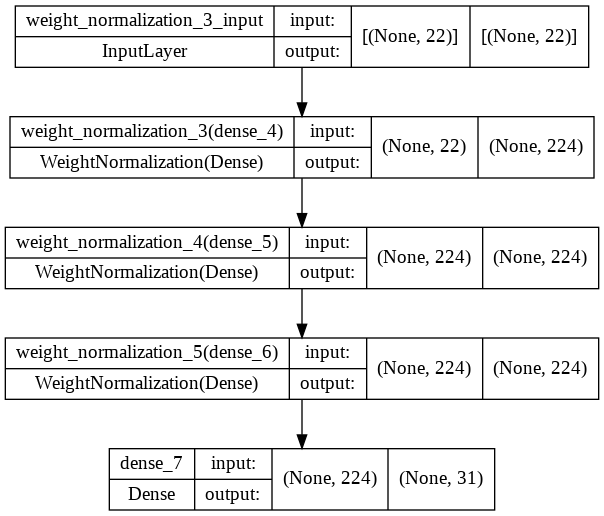

In [39]:
keras.utils.plot_model(model_based_tuner, "my_first_model_with_shape_info.png", show_shapes=True)

# Ploting

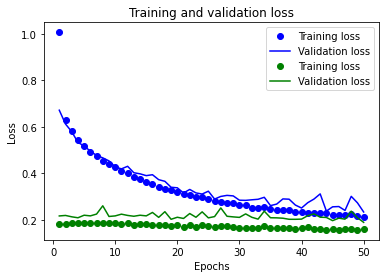

In [42]:
acc = model_based_tuner_dict['accuracy']
val_acc = model_based_tuner_dict['val_accuracy']
loss = model_based_tuner_dict['loss']
val_loss = model_based_tuner_dict['val_loss']
recall = model_based_tuner_dict['recall_1']
val_recall = model_based_tuner_dict['val_recall_1']
f1_score = model_based_tuner_dict['f1_score']
val_f1_score = model_based_tuner_dict['val_f1_score']

acc2 = model_based_tuner_dict2['accuracy']
val_acc2 = model_based_tuner_dict2['val_accuracy']
loss2 = model_based_tuner_dict2['loss']
val_loss2 = model_based_tuner_dict2['val_loss']
recall2 = model_based_tuner_dict2['recall_1']
val_recall2 = model_based_tuner_dict2['val_recall_1']
f1_score2 = model_based_tuner_dict2['f1_score']
val_f1_score2 = model_based_tuner_dict2['val_f1_score']

acc3 = model_based_tuner_dict3['accuracy']
val_acc3 = model_based_tuner_dict3['val_accuracy']
loss3 = model_based_tuner_dict3['loss']
val_loss3 = model_based_tuner_dict3['val_loss']
recall3 = model_based_tuner_dict3['recall_1']
val_recall3 = model_based_tuner_dict3['val_recall_1']
f1_score3 = model_based_tuner_dict3['f1_score']
val_f1_score3 = model_based_tuner_dict3['val_f1_score']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')

plt.plot(epochs, loss2, 'bo', label='Training loss', color='g')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss2, 'b', label='Validation loss', color='g')

# plt.plot(epochs, loss2, 'bo', label='Training loss', color='r')
# # b는 "파란 실선"입니다
# plt.plot(epochs, val_loss2, 'b', label='Validation loss', color='r')

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

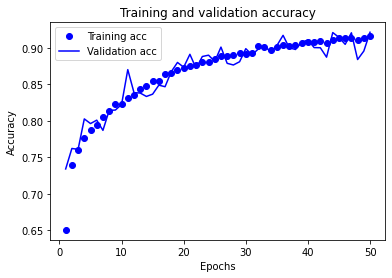

In [41]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

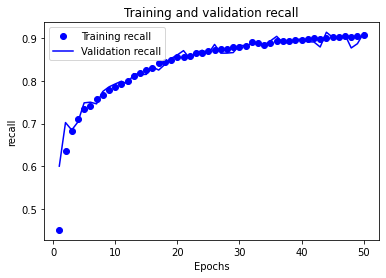

In [ ]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, recall, 'bo', label='Training recall')
plt.plot(epochs, val_recall, 'b', label='Validation recall')
plt.title('Training and validation recall')
plt.xlabel('Epochs')
plt.ylabel('recall')
plt.legend()

plt.show()

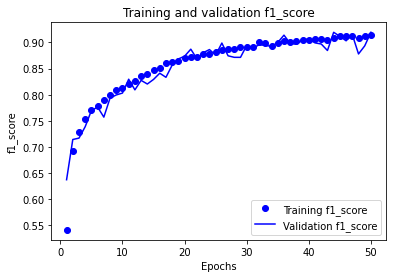

In [ ]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, f1_score, 'bo', label='Training f1_score')
plt.plot(epochs, val_f1_score, 'b', label='Validation f1_score')
plt.title('Training and validation f1_score')
plt.xlabel('Epochs')
plt.ylabel('f1_score')
plt.legend()

plt.show()

In [ ]:
X_test[0]

array([-200.  , -200.  ,  -67.28,  -72.49, -200.  , -200.  , -200.  ,
       -200.  ,  -59.4 , -200.  , -200.  , -200.  , -200.  , -200.  ,
        -69.67, -200.  , -200.  , -200.  , -200.  , -200.  , -200.  ,
       -200.  ], dtype=float32)

#Confusion Matrix

9242
[16 17 10 ...  4 16 24]
Confusion Matrix


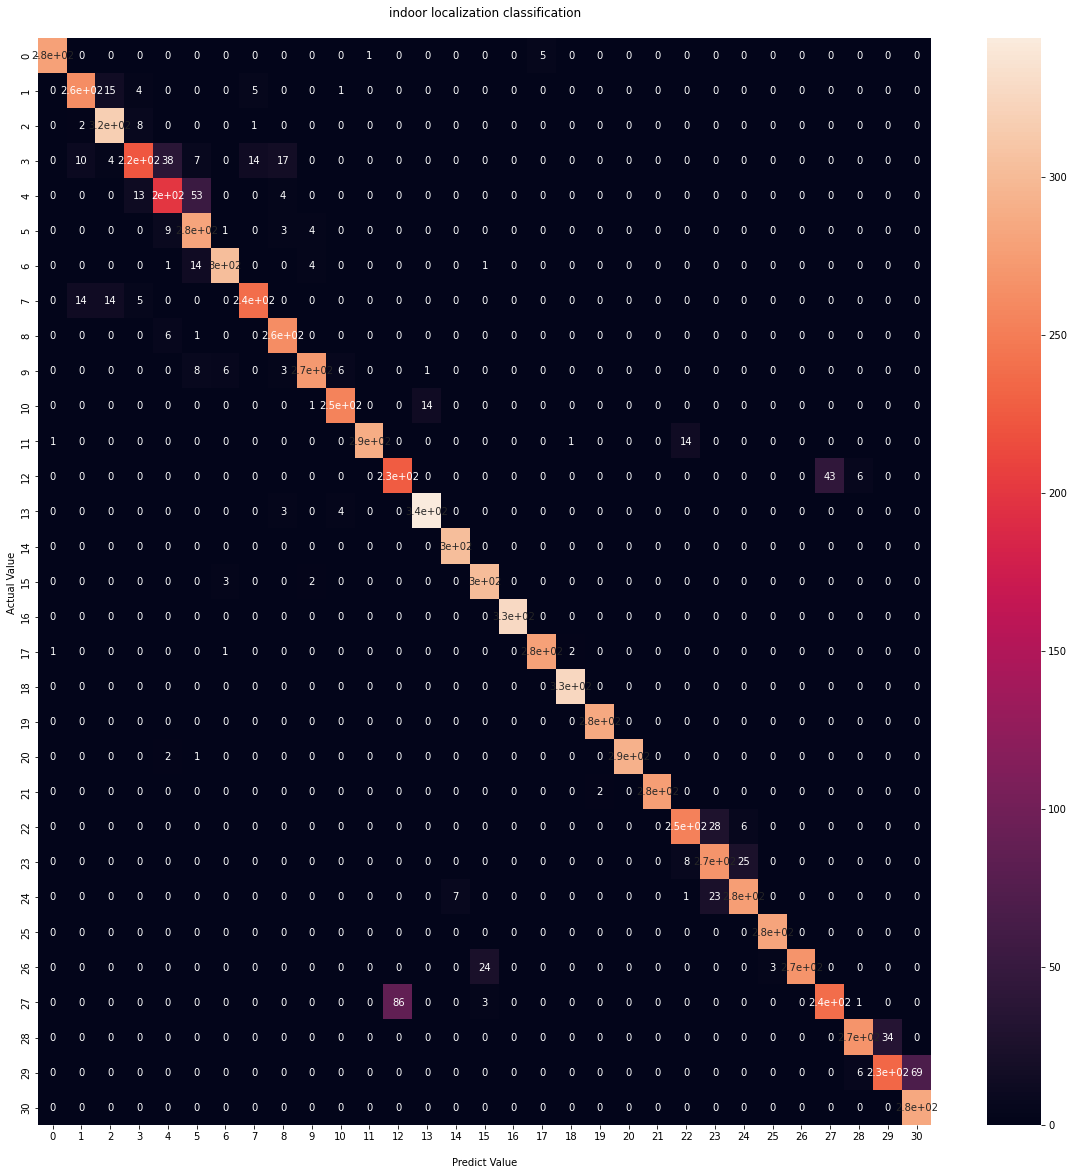

In [ ]:
from sklearn.metrics import confusion_matrix
y_test_arg=np.argmax(y_test,axis=1)
Y_pred = np.argmax(model_based_tuner.predict(X_test),axis=1)
print(len(X_test))
print(Y_pred)
print('Confusion Matrix')

cf_matrix = confusion_matrix(y_test_arg, Y_pred)

plt.figure(figsize=(20, 20)) 
ax = sns.heatmap(cf_matrix, annot = True)
ax.set_title('indoor localization classification\n')
ax.set_xlabel('\nPredict Value')
ax.set_ylabel('Actual Value ')
plt.show()

In [ ]:
X_test[1]

array([-200.  , -200.  , -200.  ,  -62.6 , -200.  , -200.  , -200.  ,
       -200.  , -200.  ,  -59.12, -200.  , -200.  ,  -63.43,  -71.14,
       -200.  , -200.  , -200.  , -200.  , -200.  , -200.  , -200.  ,
       -200.  ], dtype=float32)

In [ ]:
# # Convert the model.
# converter = tf.lite.TFLiteConverter.from_keras_model(model_based_tuner)
# tflite_model = converter.convert()

# # Save the model.
# with open('ios_beacon4_concat5.tflite', 'wb') as f:
#   f.write(tflite_model)

# TEST Data

In [ ]:
testdatas = [] 
data_name = [('S', [1,2,3,4,5,6,7,8,9]), ('E', [1,2,3]), ('R',[1,2,3,4,5]), ('H', [1,2]), ('A', [1,2,3,4,5,6,7,8,9,10,11]), ('U', [1]) ]

#Filtered_Test_U01

for data in data_name:
  for index in data[1]: 
    if index < 10:
      no_supervised = pd.DataFrame(pd.read_csv(f'../test_data/Filtered_Test_{data[0]}0{index}.csv'))
      no_supervised.drop('direction', axis=1, inplace=True)
      no_supervised.drop('timeStamp', axis=1, inplace=True)
      no_supervised.drop('heading', axis=1, inplace=True)
      no_supervised.insert(0, 'location' ,f'{data[0]}0{index}')
    else:
      no_supervised = pd.DataFrame(pd.read_csv(f'../test_data/Filtered_Test_{data[0]}{index}.csv'))
      no_supervised.drop('direction', axis=1, inplace=True)
      no_supervised.drop('heading', axis=1, inplace=True)
      no_supervised.drop('timeStamp', axis=1, inplace=True)
      no_supervised.insert(0, 'location' ,f'{data[0]}{index}')
    testdatas.append(no_supervised)


def tominus200(x) :
  if float(x) <= -90 :
    return -200
  return float(x)

beacons = ['001','002','003','004','005','006','007','008','009','010','011','012','013','014','015','016','017','018','019','020','021', '022']
for data in testdatas:
  for beacon in beacons:
    data[beacon] = data[beacon].apply(tominus200)

In [ ]:
testdatas[0]

,location,001,002,003,004,005,006,007,008,009,...,013,014,015,016,017,018,019,020,021,022
0,S01,-200.000000,-70.00000,-200.0,-88.00000,-200.000000,-200,-200.0,-200.000000,-200,...,-84.000000,-62.000000,-200,-200,-200,-200,-200,-53.000000,-200,-200
1,S01,-89.498505,-70.00000,-200.0,-86.99900,-200.000000,-200,-200.0,-200.000000,-200,...,-83.499504,-63.501500,-200,-200,-200,-200,-200,-53.000000,-200,-200
2,S01,-89.666230,-200.00000,-200.0,-200.00000,-200.000000,-200,-200.0,-89.996670,-200,...,-82.663570,-200.000000,-200,-200,-200,-200,-200,-53.000000,-200,-200
3,S01,-200.000000,-68.99667,-200.0,-85.66156,-200.000000,-200,-200.0,-200.000000,-200,...,-82.244770,-63.668220,-200,-200,-200,-200,-200,-200.000000,-200,-200
4,S01,-200.000000,-68.99751,-200.0,-84.73978,-200.000000,-200,-200.0,-89.494026,-200,...,-200.000000,-64.003494,-200,-200,-200,-200,-200,-53.503490,-200,-200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180,S01,-88.792760,-73.70121,-200.0,-84.95001,-200.000000,-200,-200.0,-200.000000,-200,...,-82.309880,-71.537890,-200,-200,-200,-200,-200,-60.398052,-200,-200
181,S01,-88.408200,-73.53934,-200.0,-200.00000,-200.000000,-200,-200.0,-200.000000,-200,...,-82.252600,-71.514366,-200,-200,-200,-200,-200,-60.293175,-200,-200
182,S01,-88.084200,-200.00000,-200.0,-200.00000,-200.000000,-200,-200.0,-200.000000,-200,...,-82.066610,-200.000000,-200,-200,-200,-200,-200,-60.149147,-200,-200
183,S01,-200.000000,-200.00000,-200.0,-84.99593,-89.910965,-200,-200.0,-200.000000,-200,...,-81.845024,-71.579346,-200,-200,-200,-200,-200,-200.000000,-200,-200


In [ ]:
for data in testdatas:
  for row_index in range(len(data)):
    if row_index % 2 == 1:
      for col_index in range(1, len(data.columns)):
        if data.iloc[row_index - 1, col_index] > data.iloc[row_index, col_index]:
          data.iloc[row_index, col_index] = data.iloc[row_index - 1, col_index]


In [ ]:
# 상위 4개를 통해서 classification 하기
for data in testdatas:
  for row_index in range(len(data)):
    column_idx = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22]
    a = sorted(data.loc[row_index].tolist()[1:])
    b = list(a)[-4:]
    isMax = [0]
    for i in range(len(data.columns)):
      for num in b:
        if data.loc[row_index][i] == num:
          isMax.append(i)

    remove_set = set(isMax)
    column_idx = [i for i in column_idx if i not in remove_set]
    data.iloc[[row_index], column_idx] = [-200 for i in range(len(column_idx))]
  

In [ ]:
for index in range(len(testdatas)):
  testdatas[index] = testdatas[index].iloc[1::2,:]

In [ ]:
for index in range(len(testdatas)):
  testdatas[index].reset_index(inplace=True)

In [ ]:
for index in range(len(testdatas)):
  testdatas[index].drop('index', axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
result_test = pd.concat(testdatas)

In [ ]:
result_test.reset_index(inplace=True)

In [ ]:
result_test.drop('index', axis=1, inplace=True)

In [ ]:
np.set_printoptions(precision=2)
le = LabelEncoder()

X = np.array(result_test.iloc[:, 1:])
y = le.fit_transform(np.array(result_test['location']).reshape(-1, 1))
y = to_categorical(y)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


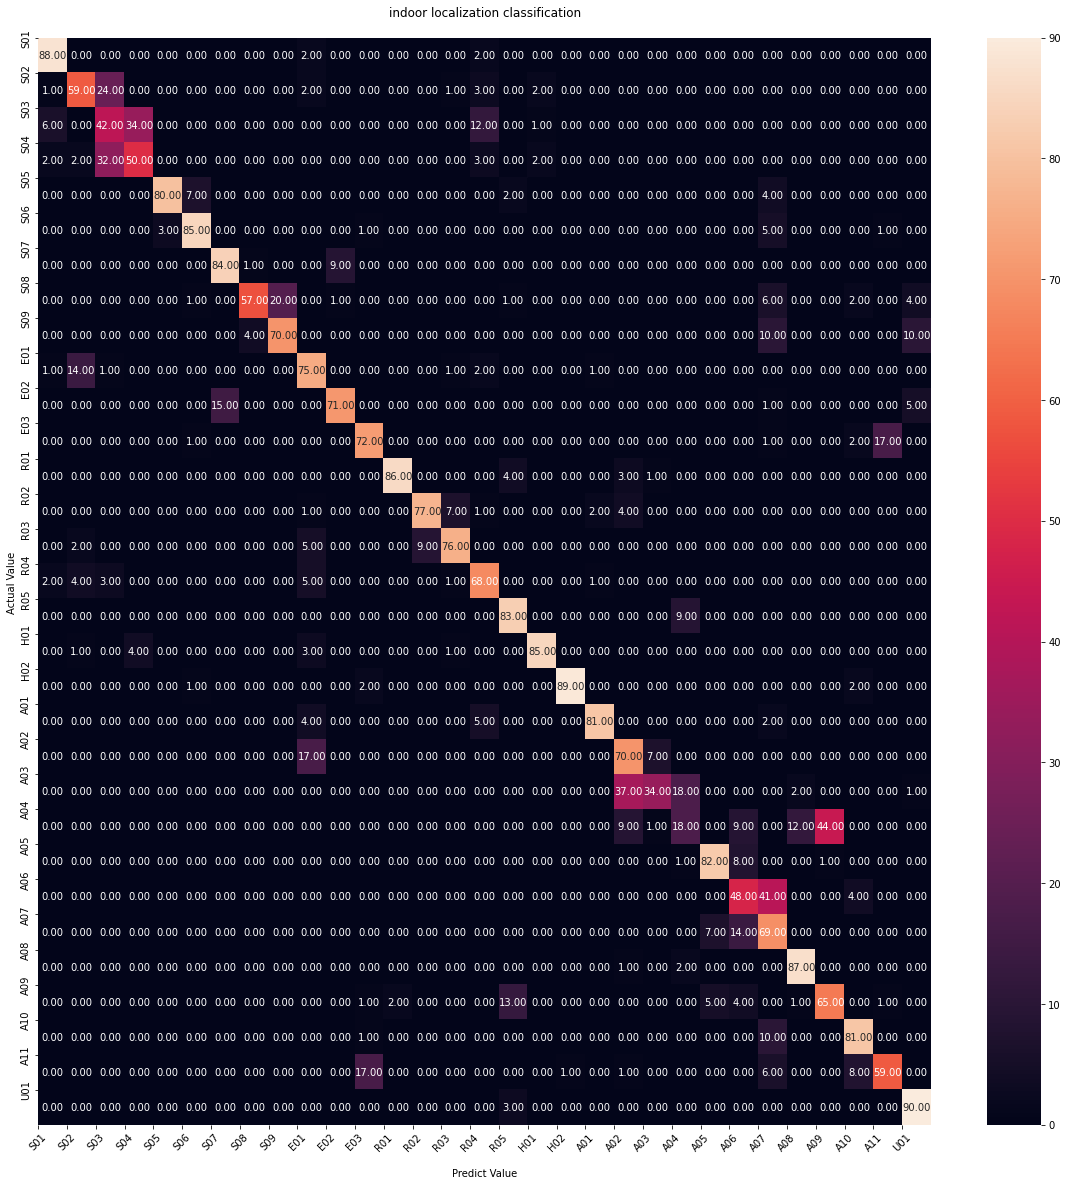

In [ ]:
from sklearn.metrics import confusion_matrix

labels = ['S01','S02', 'S03','S04','S05','S06','S07','S08','S09', 'E01','E02','E03', 'R01', 'R02', 'R03', 'R04',
           'R05', 'H01', 'H02', 'A01', 'A02', 'A03','A04','A05','A06','A07','A08','A09','A10', 'A11', 'U01']
y_test_arg=np.argmax(y,axis=1)
y_test2 = le.inverse_transform(y_test_arg)
Y_pred = np.argmax(model_based_tuner.predict(X),axis=1)
Y_pred2 = le.inverse_transform(Y_pred)

# print(Y_pred)
# print('Confusion Matrix')
tick_marks = np.arange(len(labels))
cf_matrix = confusion_matrix(y_test2, Y_pred2, labels = labels)
cmn = cf_matrix.astype('float') / cf_matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(20, 20)) 
ax = sns.heatmap(cf_matrix, annot = True, fmt='.2f')
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)

ax.set_title('indoor localization classification\n')
ax.set_xlabel('\nPredict Value')
ax.set_ylabel('Actual Value ')
plt.show()

In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

print("f1score: ", f1_score(y_true=y_test_arg, y_pred=Y_pred, average='weighted'))
print("accuracy: ", accuracy_score(y_true=y_test_arg, y_pred=Y_pred))
print("precision: ", precision_score(y_true=y_test_arg, y_pred=Y_pred, average='weighted'))
print("recall: ", recall_score(y_true=y_test_arg, y_pred=Y_pred,  average='weighted'))

f1score:  0.7578894760300156
accuracy:  0.7612565445026178
precision:  0.7701327391007913
recall:  0.7612565445026178


In [ ]:
y_test_arg

array([21, 21, 21, ..., 30, 30, 30])

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc


fpr = dict()
tpr = dict()
roc_auc = dict()

y_score = model_based_tuner.predict(X)

for i in range(31):
  fpr[i], tpr[i], _ = roc_curve(y[:, i], y_score[:, i])
  roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(y.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [ ]:
roc_count = 0

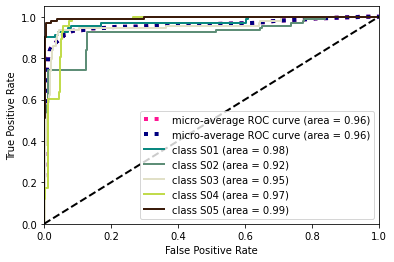

In [ ]:
from numpy.lib.function_base import interp
from itertools import cycle
import random

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(31)]))

mean_tpr = np.zeros_like(all_fpr)
for i in range(31):
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= 31

fpr['micro'] = all_fpr
tpr['micro'] = mean_tpr
roc_auc['micro'] = auc(fpr['micro'], tpr['micro'])

plt.plot(fpr['micro'], tpr['micro'], label='micro-average ROC curve (area = {0:0.2f})'
''.format(roc_auc['micro']),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr['micro'], tpr['micro'], label='micro-average ROC curve (area = {0:0.2f})'
''.format(roc_auc['micro']),
         color='navy', linestyle=':', linewidth=4)

colors = []
for i in range(31):
  colors.append("#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]))



for i, color in zip(range(roc_count, 5), colors):
  
  # plt.plot(fpr[i], tpr[i], color=color, lw=2, label='ROC curve of class {0} (area = {1:0.2f})'''.format(i, roc_auc[i]))
  plt.plot(fpr[i], tpr[i], color=color, lw=2, label='class {0} (area = {1:0.2f})'''.format(labels[i], roc_auc[i]))

plt.plot([0,1], [0,1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

In [ ]:
from sklearn.metrics import classification_report

report = classification_report(y_test2, Y_pred2, target_names=labels)

In [ ]:
# model_based_tuner.save('ios_beacon_DNN_4')

INFO:tensorflow:Assets written to: ios_beacon_DNN_4/assets


INFO:tensorflow:Assets written to: ios_beacon_DNN_4/assets
